In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt

## BinaryClassification

c:\Users\alant\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


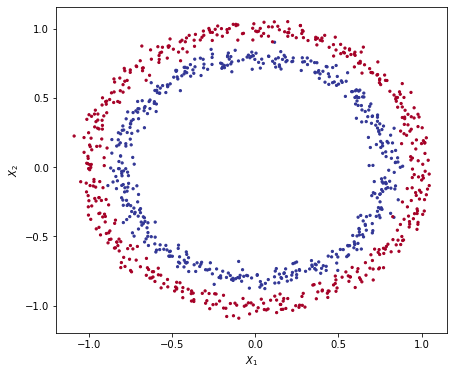

In [2]:
# create classification data
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, noise=0.04, random_state=42)

plt.figure(figsize=(7,6))
plt.scatter(X[:,0], X[:,1], c=y, s=5, cmap=plt.cm.RdYlBu)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$');

In [3]:
X.shape, y.shape

((1000, 2), (1000,))

before training we must change to torch tensor

In [4]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7482,  0.2391],
         [-0.7451,  0.1610],
         [-0.8226,  0.1976],
         [-0.4114,  0.6826],
         [ 0.4439, -0.8958]]),
 tensor([1., 1., 1., 1., 0.]))

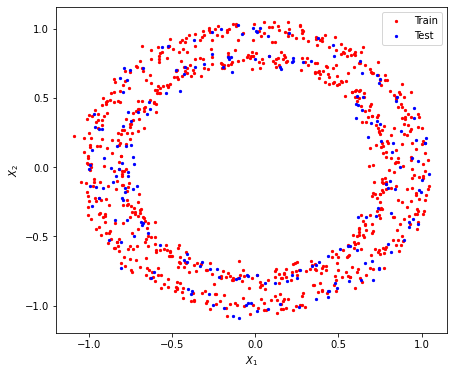

In [5]:
# split the data
np.random.seed(42)
train_size = int(0.8 * len(X))
random_index = np.random.permutation(len(X))
X_train, y_train = X[random_index[:train_size]], y[random_index[:train_size]]
X_test, y_test = X[random_index[train_size:]], y[random_index[train_size:]]

plt.figure(figsize=(7,6))
plt.scatter(X_train[:,0], X_train[:,1], c='red', s=5, label='Train')
plt.scatter(X_test[:,0], X_test[:,1], c='blue', s=5, label='Test')
plt.legend()
plt.xlabel('$X_1$')
plt.ylabel('$X_2$');

In [6]:
# building the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CircleModel(nn.Module) :
    def __init__(self) :
        super().__init__() 
        # each layer recept the output from previous layer
        self.linear_1 = nn.Linear(in_features=2, out_features=10)
        self.linear_2 = nn.Linear(in_features=10, out_features=10)
        self.linear_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # handle with non-linear data
        self.sigmoid = nn.Sigmoid() # output layer for binary classificaiton

    def forward(self, x) :
        # put the RELU activation between each layer
        return self.sigmoid(self.linear_3(self.relu(self.linear_2(self.relu(self.linear_1(x))))))

model_v1 = CircleModel().to(device)
model_v1

CircleModel(
  (linear_1): Linear(in_features=2, out_features=10, bias=True)
  (linear_2): Linear(in_features=10, out_features=10, bias=True)
  (linear_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [7]:
# setup Loss and Optimizer
loss_fn = nn.BCELoss() # Binary Cross Entropy loss
optimizer = torch.optim.SGD(model_v1.parameters(), lr=0.2)

# accuracy function
def accuracy_fn(y_true, y_pred) :
    correct = torch.eq(y_true, y_pred).sum().item() # eq = equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [8]:
# train the model
torch.manual_seed(42)
epochs = 1000

# put all data on the same device as the model
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs) :

    model_v1.train()
    y_logits = model_v1(X_train).squeeze()
    y_pred = torch.round(y_logits) # 0 or 1

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    model_v1.eval()
    with torch.inference_mode() :
        test_logits = model_v1(X_test).squeeze()
        test_pred = torch.round(test_logits) # 0 or 1

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69470, Accuracy: 50.38% | Test Loss: 0.69441, Test Accuracy: 48.00%
Epoch: 100 | Loss: 0.68865, Accuracy: 56.00% | Test Loss: 0.68989, Test Accuracy: 53.00%
Epoch: 200 | Loss: 0.68209, Accuracy: 60.62% | Test Loss: 0.68508, Test Accuracy: 57.50%
Epoch: 300 | Loss: 0.66783, Accuracy: 63.12% | Test Loss: 0.67181, Test Accuracy: 61.50%
Epoch: 400 | Loss: 0.62869, Accuracy: 76.12% | Test Loss: 0.63325, Test Accuracy: 78.50%
Epoch: 500 | Loss: 0.50188, Accuracy: 96.50% | Test Loss: 0.50080, Test Accuracy: 95.00%
Epoch: 600 | Loss: 0.45871, Accuracy: 71.62% | Test Loss: 0.46879, Test Accuracy: 68.50%
Epoch: 700 | Loss: 0.35393, Accuracy: 80.88% | Test Loss: 0.36192, Test Accuracy: 79.50%
Epoch: 800 | Loss: 0.20376, Accuracy: 93.00% | Test Loss: 0.20790, Test Accuracy: 93.00%
Epoch: 900 | Loss: 0.09354, Accuracy: 99.00% | Test Loss: 0.08945, Test Accuracy: 99.50%


In [9]:
# predictions
model_v1.eval()
with torch.inference_mode() :
    y_preds_train = torch.round(model_v1(X_train)).squeeze()
    y_preds_test = torch.round(model_v1(X_test)).squeeze()

y_preds_test[:10], y_test[:10]

(tensor([0., 1., 0., 1., 1., 1., 0., 1., 0., 0.]),
 tensor([0., 1., 0., 1., 1., 1., 0., 1., 0., 0.]))

In [10]:
def plot_decistion_bounary(model, resolution, X, y) :
    x_min, x_max = X[:,0].min()-0.1, X[:,1].max()+0.1
    y_min, y_max = X[:,0].min()-0.1, X[:,1].max()+0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))

    x_new = np.c_[xx.ravel(), yy.ravel()]
    x_new = torch.from_numpy(x_new).type(torch.float)

    model.eval()
    with torch.inference_mode() :
        y_preds = model(x_new) # prediction
    
    y_preds = torch.reshape(y_preds, (xx.shape))

    plt.contourf(xx, yy, y_preds, alpha=0.5, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:,0], X[:,1], c=y, s=5, cmap=plt.cm.RdYlBu)
    plt.xlabel('$X1$')
    plt.ylabel('$X2$')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

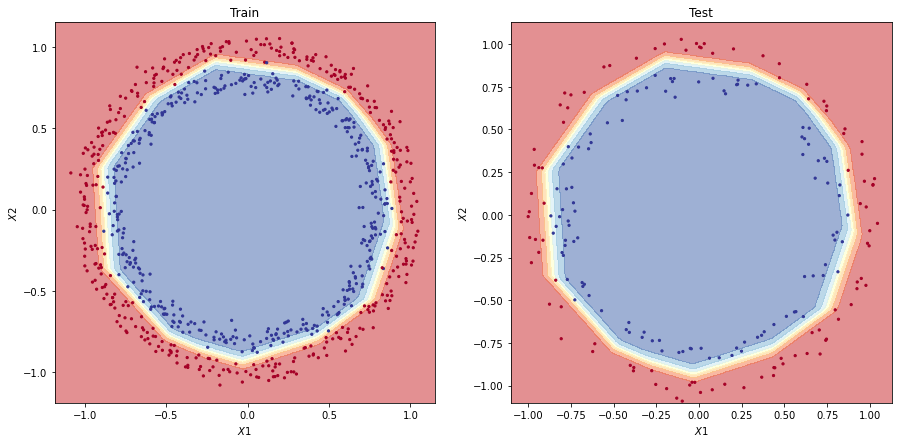

In [11]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plot_decistion_bounary(model_v1, 100, X_train, y_train)
plt.title('Train')

plt.subplot(1,2,2)
plot_decistion_bounary(model_v1, 100, X_test, y_test)
plt.title('Test');

## MultiClassification

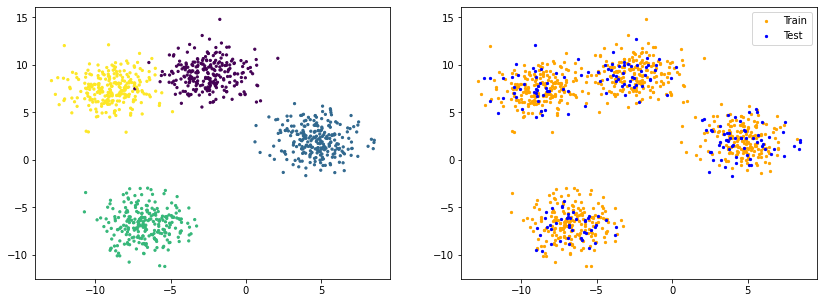

In [128]:
# create data
from sklearn.datasets import make_blobs

n_samples = 1000
num_classes = 4
num_features = 2
X, y = make_blobs(n_samples, n_features = num_features, centers = num_classes, cluster_std=1.5, random_state=42)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split the data
np.random.seed(42)
train_size = int(0.8 * len(X))
random_index = np.random.permutation(len(X))
X_train, y_train = X[random_index[:train_size]], y[random_index[:train_size]]
X_test, y_test = X[random_index[train_size:]], y[random_index[train_size:]]

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=y, s=5)

plt.subplot(1,2,2)
plt.scatter(X_train[:,0], X_train[:,1], c='orange', s=5, label='Train')
plt.scatter(X_test[:,0], X_test[:,1], c='blue', s=5, label='Test')
plt.legend();

In [129]:
# build model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class BlobClassification(nn.Module) :
    def __init__(self, input_features, output_features, hidden_units=8) :
        super().__init__()
        
        self.layer_1 = nn.Linear(input_features, hidden_units)
        self.layer_2 = nn.Linear(hidden_units, hidden_units)
        self.layer_3 = nn.Linear(hidden_units, output_features)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # for output MultiClassification
    
    def forward(self, x) :
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.layer_3(x)
        x = self.softmax(x)
        return x

model_blob = BlobClassification(num_features, num_classes).to(device)
model_blob

BlobClassification(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [134]:
model_blob(X_train.to(device))[:5]

tensor([[6.6414e-03, 9.9333e-01, 1.7876e-05, 7.5662e-06],
        [1.5016e-02, 5.8065e-04, 9.6395e-03, 9.7476e-01],
        [3.4397e-02, 2.1133e-02, 8.9822e-01, 4.6249e-02],
        [1.6687e-02, 9.8103e-01, 1.6896e-03, 5.9759e-04],
        [9.8586e-01, 1.3967e-02, 3.4180e-05, 1.3632e-04]],
       grad_fn=<SliceBackward0>)

In [135]:
model_blob(X_train.to(device)).argmax(dim=1)[:5]

tensor([1, 3, 2, 1, 0])

In [132]:
# Setup Loss and Optimizer
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model_blob.parameters(), lr=0.1)

In [133]:
# Train the model
torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs) :
    model_blob.train()

    y_logits = model_blob(X_train)
    y_pred =  torch.argmax(y_logits, dim=1) # find the most proba to PredClass
  
    loss = loss_fn(y_logits, y_train.type(torch.LongTensor))
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()

    model_blob.eval()
    with torch.inference_mode() :
        test_logits = model_blob(X_test)
        test_pred = torch.argmax(test_logits, dim=1) # find the most proba to PredClass

        test_loss = loss_fn(test_logits, y_test.type(torch.LongTensor))
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 10 == 0 or (epoch+1) == epochs :
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.32256, Acc: 39.12% | Test Loss: 1.31424, Test Acc: 47.00%
Epoch: 10 | Loss: 1.21712, Acc: 65.00% | Test Loss: 1.18463, Test Acc: 74.50%
Epoch: 20 | Loss: 1.14044, Acc: 93.25% | Test Loss: 1.10481, Test Acc: 96.50%
Epoch: 30 | Loss: 1.08290, Acc: 93.62% | Test Loss: 1.04877, Test Acc: 95.50%
Epoch: 40 | Loss: 1.01907, Acc: 96.00% | Test Loss: 0.98977, Test Acc: 98.50%
Epoch: 50 | Loss: 0.96665, Acc: 96.62% | Test Loss: 0.94260, Test Acc: 99.50%
Epoch: 60 | Loss: 0.93219, Acc: 96.88% | Test Loss: 0.91099, Test Acc: 99.50%
Epoch: 70 | Loss: 0.90434, Acc: 98.12% | Test Loss: 0.88475, Test Acc: 99.50%
Epoch: 80 | Loss: 0.86955, Acc: 98.88% | Test Loss: 0.85209, Test Acc: 99.50%
Epoch: 90 | Loss: 0.82225, Acc: 99.12% | Test Loss: 0.81026, Test Acc: 99.50%
Epoch: 99 | Loss: 0.79268, Acc: 99.00% | Test Loss: 0.78641, Test Acc: 99.50%


<img src='./images/longtensor.png' width=500px>

In [137]:
# predictions
model_blob.eval()
with torch.inference_mode() :
    y_logits_train = model_blob(X_train)
    y_logits_test = model_blob(X_test)

y_logits_test[:5]

tensor([[1.4591e-02, 2.0421e-04, 3.0396e-03, 9.8217e-01],
        [2.0863e-01, 7.8922e-01, 1.4322e-03, 7.1942e-04],
        [7.2547e-03, 2.6308e-04, 6.7781e-03, 9.8570e-01],
        [9.5595e-01, 2.1358e-03, 1.6503e-03, 4.0266e-02],
        [1.4052e-02, 4.4364e-04, 7.4145e-03, 9.7809e-01]])

In [139]:
y_preds_train = torch.argmax(y_logits_train, dim=1)
y_preds_test = torch.argmax(y_logits_test, dim=1)
y_preds_test[:5]

tensor([3, 1, 3, 0, 3])

In [140]:
# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds_test[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_test, y_preds_test)}%")

Predictions: tensor([3, 1, 3, 0, 3, 2, 1, 3, 3, 3])
Labels: tensor([3., 1., 3., 0., 3., 2., 1., 3., 3., 3.])
Test accuracy: 99.5%


In [152]:
def plot_decistion_bounary(model, resolution, X, y) :
    x_min, x_max = X[:,0].min()-0.1, X[:,1].max()+0.1
    y_min, y_max = X[:,0].min()-0.1, X[:,1].max()+0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))

    x_new = np.c_[xx.ravel(), yy.ravel()]
    x_new = torch.from_numpy(x_new).type(torch.float)

    model.eval()
    with torch.inference_mode() :
        y_logits = model(x_new) # prediction
        y_preds = torch.argmax(y_logits, dim=1) # change this

    y_preds = torch.reshape(y_preds, (xx.shape))

    plt.contourf(xx, yy, y_preds, alpha=0.5, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:,0], X[:,1], c=y, s=5, cmap=plt.cm.RdYlBu)
    plt.xlabel('$X1$')
    plt.ylabel('$X2$')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

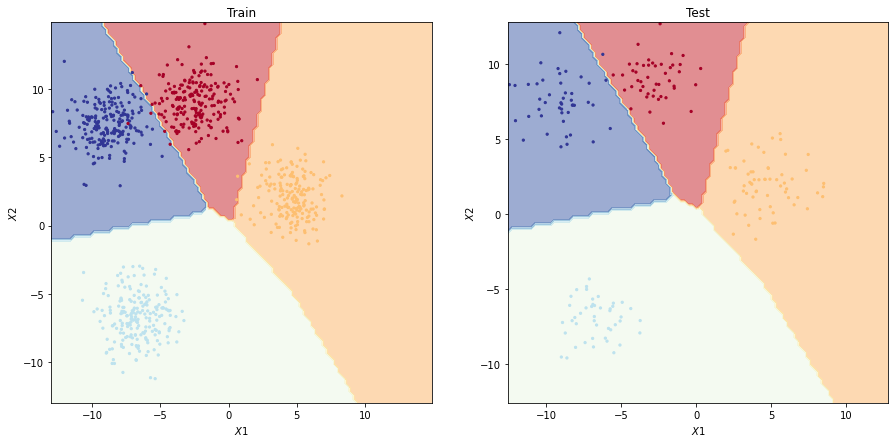

In [153]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plot_decistion_bounary(model_blob, 100, X_train, y_train)
plt.title('Train')

plt.subplot(1,2,2)
plot_decistion_bounary(model_blob, 100, X_test, y_test)
plt.title('Test');